In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.decomposition import PCA

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=933d97a3904765eeb9065b72a3b52ad9a03d5312599dcb5ab9c83e0f6073e654
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
# --- Step 1: Load the Data ---
print("--- Step 1: Loading Data ---")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print("Datasets loaded successfully.")
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}\n")

--- Step 1: Loading Data ---
Datasets loaded successfully.
Train data shape: (8693, 14)
Test data shape: (4277, 13)



--- Step 2: Exploratory Data Analysis (EDA) ---
Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

Train DataFrame Description:
       PassengerId HomePlanet CryoSleep   

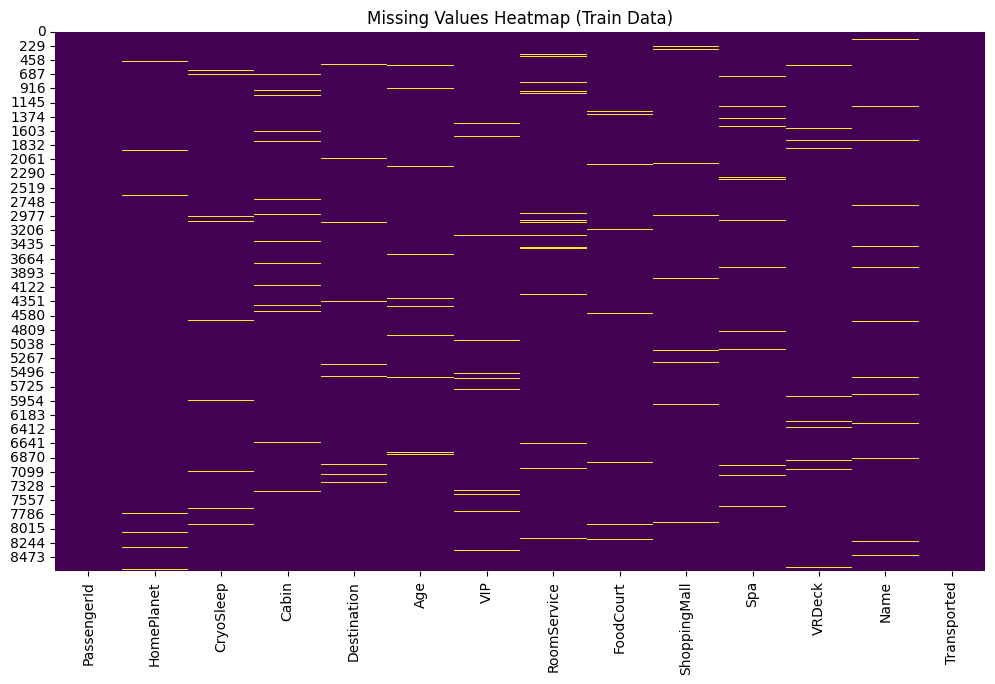

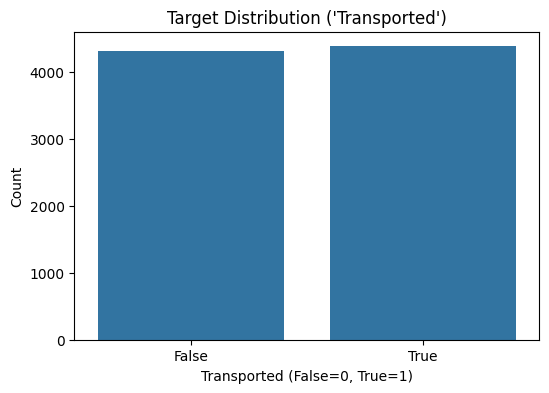

<Figure size 1500x1000 with 0 Axes>

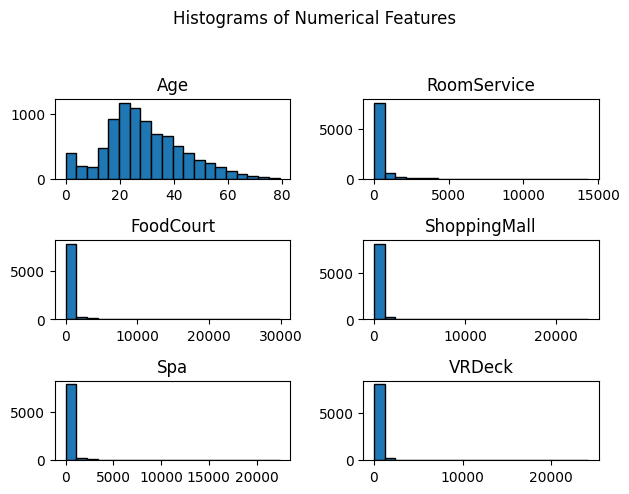

In [ ]:
# --- Step 2: Exploratory Data Analysis (EDA) ---
print("--- Step 2: Exploratory Data Analysis (EDA) ---")

# Basic information and descriptive statistics for training data
print("Train DataFrame Info:")
train_df.info()
print("\nTrain DataFrame Description:")
print(train_df.describe(include='all'))

# Missing values heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (Train Data)")
plt.show()

# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df)
plt.title("Target Distribution ('Transported')")
plt.xlabel("Transported (False=0, True=1)")
plt.ylabel("Count")
plt.show()

# Histograms for numerical features
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
plt.figure(figsize=(15, 10))
train_df[numeric_cols].hist(bins=20, edgecolor='black', grid=False)
plt.suptitle("Histograms of Numerical Features", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
plt.show()

In [ ]:
# --- Step 3: Preprocessing ---
print("--- Step 3: Preprocessing ---")

# Separate target variable before imputation and encoding
train_labels = train_df['Transported'].astype(int)
train_df_processed = train_df.drop(['Transported'], axis=1)

# Combine train and test for consistent preprocessing
combined_df = pd.concat([train_df_processed, test_df], ignore_index=True)

# Identify numerical and categorical features
num_features_combined = combined_df.select_dtypes(include=['float64', 'int64']).columns
cat_features_combined = combined_df.select_dtypes(include='object').columns

# Impute missing numerical values with the median
for col in num_features_combined:
    median_val = combined_df[col].median()
    combined_df[col] = combined_df[col].fillna(median_val)
    print(f"Filled missing numerical values in '{col}' with median: {median_val}")

# Impute missing categorical values with 'Unknown'
for col in cat_features_combined:
    combined_df[col] = combined_df[col].fillna('Unknown')
    print(f"Filled missing categorical values in '{col}' with 'Unknown'")

# Drop irrelevant features (PassengerId, Name, Cabin)
# PassengerId is needed for submission, so we'll store it from the original test_df
passenger_ids = test_df['PassengerId']
combined_df = combined_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1)
print("Dropped 'PassengerId', 'Name', 'Cabin' columns.")

# One-hot encode categorical features
print("Performing one-hot encoding on categorical features...")
combined_encoded = pd.get_dummies(combined_df, drop_first=True)
print(f"Shape after one-hot encoding: {combined_encoded.shape}\n")

# Split back into training and testing sets
X_train_pre_pca = combined_encoded.iloc[:len(train_labels), :]
X_test_pre_pca = combined_encoded.iloc[len(train_labels):, :]
y_train = train_labels



print(f"Cumulative explained variance by {n_components_pca} components: {pca.explained_variance_ratio_.sum():.4f}\n")


--- Step 3: Preprocessing ---
Filled missing numerical values in 'Age' with median: 27.0
Filled missing numerical values in 'RoomService' with median: 0.0
Filled missing numerical values in 'FoodCourt' with median: 0.0
Filled missing numerical values in 'ShoppingMall' with median: 0.0
Filled missing numerical values in 'Spa' with median: 0.0
Filled missing numerical values in 'VRDeck' with median: 0.0
Filled missing categorical values in 'PassengerId' with 'Unknown'
Filled missing categorical values in 'HomePlanet' with 'Unknown'
Filled missing categorical values in 'CryoSleep' with 'Unknown'
Filled missing categorical values in 'Cabin' with 'Unknown'
Filled missing categorical values in 'Destination' with 'Unknown'
Filled missing categorical values in 'VIP' with 'Unknown'
Filled missing categorical values in 'Name' with 'Unknown'
Dropped 'PassengerId', 'Name', 'Cabin' columns.
Performing one-hot encoding on categorical features...
Shape after one-hot encoding: (12970, 16)

Cumulative 

--- Step 4: PCA for Feature Selection ---
Data standardized using StandardScaler.
PCA applied. Reduced features to 6 principal components.
X_train_pca_df shape: (8693, 6)
X_test_pca_df shape: (4277, 6)



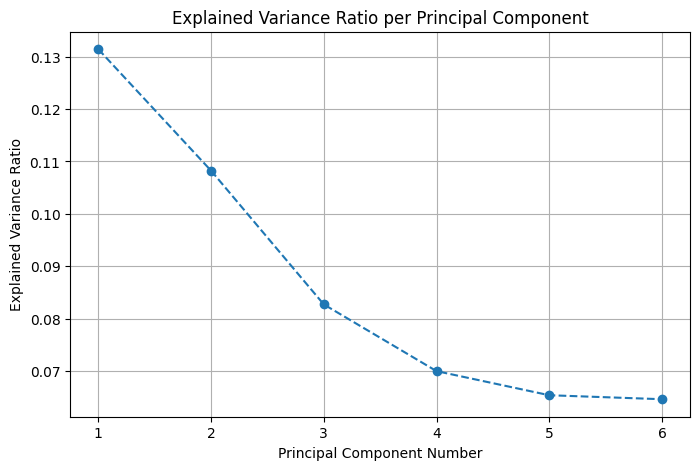

Cumulative explained variance by 6 components: 0.5222



In [ ]:
# --- Step 4: PCA for Feature Selection ---
print("--- Step 4: PCA for Feature Selection ---")

# Standardize the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pre_pca)
X_test_scaled = scaler.transform(X_test_pre_pca)
print("Data standardized using StandardScaler.")

# Apply PCA to reduce dimensionality. Selecting 6 principal components.
# You can change n_components to 5 if desired.
n_components_pca = 6 # Set to 5 or 6 as requested # MODIFIED: Set PCA components
pca = PCA(n_components=n_components_pca) # MODIFIED: PCA initialization
X_train_pca = pca.fit_transform(X_train_scaled) # MODIFIED: PCA fit and transform
X_test_pca = pca.transform(X_test_scaled) # MODIFIED: PCA transform

# Convert PCA results back to DataFrame for easier handling
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components_pca)]) # MODIFIED: Convert to DataFrame
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components_pca)]) # MODIFIED: Convert to DataFrame

print(f"PCA applied. Reduced features to {n_components_pca} principal components.")
print(f"X_train_pca_df shape: {X_train_pca_df.shape}")
print(f"X_test_pca_df shape: {X_test_pca_df.shape}\n")

# Plot explained variance ratio # NEW: Plot for explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components_pca + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

print(f"Cumulative explained variance by {n_components_pca} components: {pca.explained_variance_ratio_.sum():.4f}\n")


In [ ]:
# --- Step 5: Train-Validation Split ---
print("--- Step 5: Train-Validation Split ---")
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pca_df, y_train, test_size=0.2, random_state=42) # MODIFIED: Use PCA-transformed data
print(f"Training set shape: {X_tr.shape}, Validation set shape: {X_val.shape}\n")

--- Step 5: Train-Validation Split ---
Training set shape: (6954, 6), Validation set shape: (1739, 6)



In [ ]:
# --- Step 6: Model Training with Hyperparameter Tuning (Random Forest Classifier) ---
print("--- Step 6: Model Training with Hyperparameter Tuning ---")
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200], # Reduced n_estimators for faster tuning
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1) # Reduced cv for speed
grid_rf.fit(X_tr, y_tr) # MODIFIED: Fit on PCA-transformed data
best_model = grid_rf.best_estimator_
print("Best Parameters found by GridSearchCV:", grid_rf.best_params_)
print(f"Best cross-validation accuracy: {grid_rf.best_score_:.4f}\n")

--- Step 6: Model Training with Hyperparameter Tuning ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters found by GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.7590



In [ ]:
# --- Step 7: Evaluation on Validation Set ---
print("--- Step 7: Evaluation on Validation Set ---")
y_val_pred = best_model.predict(X_val) # MODIFIED: Predict on PCA-transformed data
y_train_pred = best_model.predict(X_tr) # MODIFIED: Predict on PCA-transformed data

train_acc = accuracy_score(y_tr, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}\n")

print("Classification Report (Validation Set):\n")
print(classification_report(y_val, y_val_pred))

--- Step 7: Evaluation on Validation Set ---
Train Accuracy: 0.8392
Validation Accuracy: 0.7821

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       861
           1       0.80      0.76      0.78       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



--- Step 8: Confusion Matrix ---


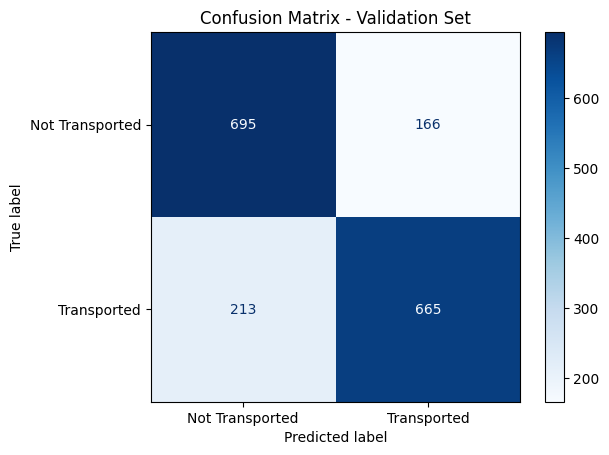

In [ ]:
# --- Step 8: Confusion Matrix ---
print("--- Step 8: Confusion Matrix ---")
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Transported", "Transported"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()


--- Step 9: Accuracy Plots ---


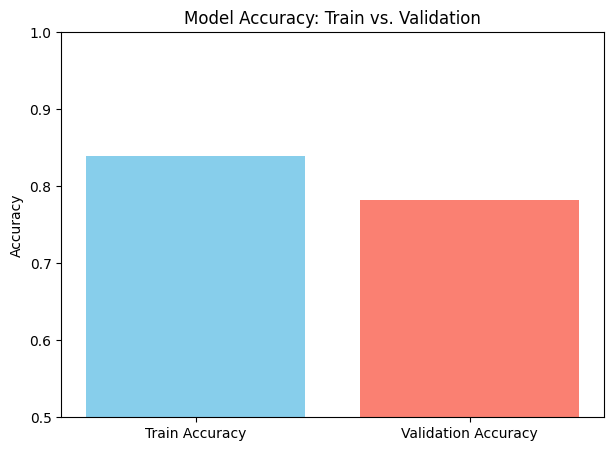


Plotting Validation Accuracy vs. Number of Estimators:


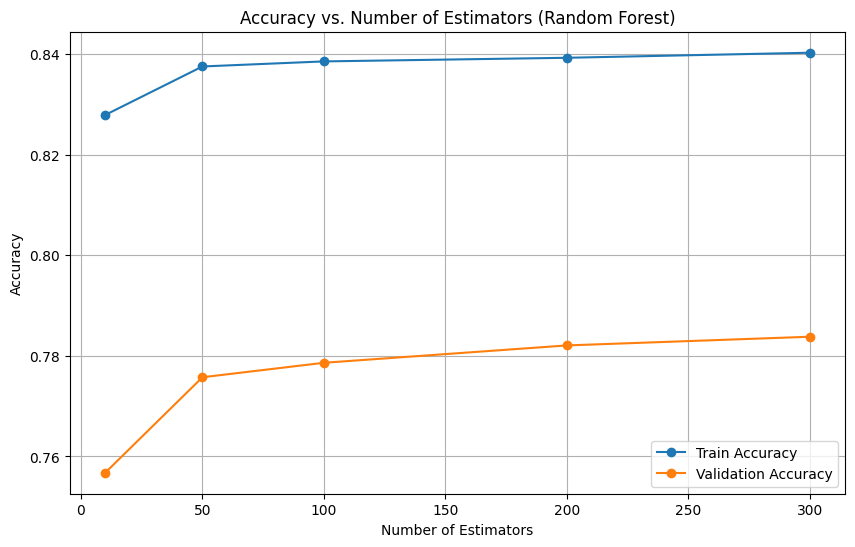

In [ ]:
# --- Step 9: Accuracy Plots ---
print("--- Step 9: Accuracy Plots ---")

# Accuracy Comparison Bar Chart (Train vs. Validation) # NEW: Bar chart for accuracy comparison
plt.figure(figsize=(7, 5))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'salmon'])
plt.ylim(0.5, 1.0)
plt.title("Model Accuracy: Train vs. Validation")
plt.ylabel("Accuracy")
plt.show()

# Plotting accuracy vs. number of estimators (as a proxy for "training plots") # NEW: Accuracy vs. Estimators plot
# Note: Random Forest is not an iterative model that has 'loss' per epoch.
# This plot shows how accuracy changes as more trees are added to the ensemble.
print("\nPlotting Validation Accuracy vs. Number of Estimators:")
n_estimators_range = [10, 50, 100, 200, 300] # Example range, adjust as needed
train_accuracies_estimators = []
val_accuracies_estimators = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, max_depth=best_model.max_depth,
                                     min_samples_split=best_model.min_samples_split,
                                     min_samples_leaf=best_model.min_samples_leaf,
                                     random_state=42, n_jobs=-1)
    rf_temp.fit(X_tr, y_tr)
    train_accuracies_estimators.append(accuracy_score(y_tr, rf_temp.predict(X_tr)))
    val_accuracies_estimators.append(accuracy_score(y_val, rf_temp.predict(X_val)))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies_estimators, marker='o', label='Train Accuracy')
plt.plot(n_estimators_range, val_accuracies_estimators, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Number of Estimators (Random Forest)')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


--- Logistic Regression ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.7326049453709028
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.84      0.76       861
           1       0.80      0.63      0.70       878

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739



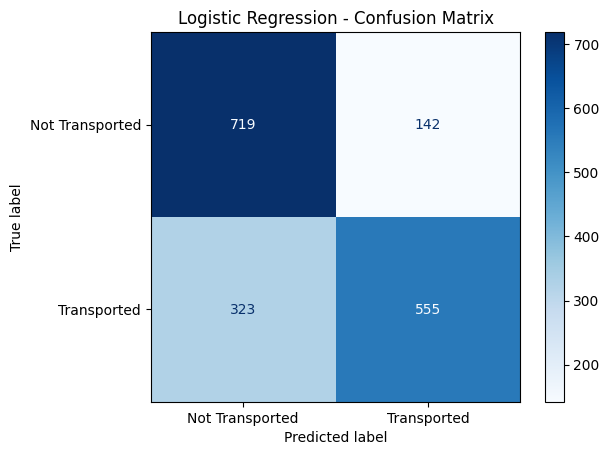

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

print("\n--- Logistic Regression ---")

logreg = LogisticRegression(random_state=42, max_iter=1000)
param_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_logreg = GridSearchCV(logreg, param_logreg, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_logreg.fit(X_tr, y_tr)

logreg_best = grid_logreg.best_estimator_
print("Best Parameters:", grid_logreg.best_params_)

y_pred_logreg = logreg_best.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_logreg))
print("Classification Report:\n", classification_report(y_val, y_pred_logreg))

# Confusion Matrix
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Not Transported', 'Transported'])
disp_logreg.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()
